<a href="https://colab.research.google.com/github/zzunebye/Capstone-code-data/blob/main/_CLF_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab

In [ ]:
!pip install transformers
!pip install torch

In [57]:
import os
print(os.getcwd())

# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('./MyDrive')

/content/MyDrive/My Drive/Capstone/code_data


ValueError: ignored

In [ ]:
cd MyDrive/MyDrive/Capstone/code_data

[Errno 107] Transport endpoint is not connected: 'MyDrive/MyDrive/Capstone/code_data'
/content/MyDrive/MyDrive/Capstone/code_data


In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

# BERT + SPARSE


## Functions

In [ ]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, f1_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import time

import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### Class

In [ ]:
class BertClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, sparse_features):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### Functions

In [ ]:
def getDevice():
  if torch.cuda.is_available():       
      device = torch.device("cuda")
      print(f'There are {torch.cuda.device_count()} GPU(s) available.')
      print('Device name:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def text_preprocessing(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = text.lower()
    # text = re.sub(r'(@.*?)[\s]', ' ', text)
    # text = re.sub(r"(#)(\S+)", r'\1 \2', text)

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'

    # text = re.sub(r"@\S+", "@", text)   # mention -> '@'
    # text = re.sub(r"@[^\s]+", "@", text)   # mention -> '@'

    # sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocessing_for_bert(data): 

    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs (빈 리스트 2개 생성)
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            # max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask

            # max_length=True,                  # Max length to truncate/pad
            padding='max_length'
        )

        # Add the outputs to the lists (위의 빈 리스트에 상응하는 값 추가)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors (리스트들을 텐서화)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    criterion = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, criterion

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(
                t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(
                    f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def data_process(X_train, y_train, X_val, y_val, batch_size=16):
  # Concatenate train data and test data
  all_tweets = np.concatenate([X_train, X_val])

  # Encode our concatenated data
  encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

  # Find the maximum length
  max_len = max([len(sent) for sent in encoded_tweets])
  print('Max length: ', max_len)

  # Specify `MAX_LEN`
  MAX_LEN = max_len

  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('\nTokenizing data...')
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)

  # Convert other data types to torch.Tensor
  train_labels = torch.tensor(y_train)
  val_labels = torch.tensor(y_val)

  # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 8

  # Create the DataLoader for our training set
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set
  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

  return train_dataloader, val_dataloader

def train_process(train_dataloader, val_dataloader, epoch=4):
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=epoch)

  train(bert_classifier, train_dataloader, loss_fn, epochs=4, evaluation=True)

  return bert_classifier

def testing_process(bert_classifier, X_val, y_val):
  #  Run `preprocessing_for_bert` on the test set
  print('Tokenizing data...')
  test_inputs, test_masks = preprocessing_for_bert(X_val)

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

  # Compute predicted probabilities on the test set
  probs = bert_predict(bert_classifier, test_dataloader)

  # Get predictions from the probabilities
  threshold = 0.5
  preds = np.where(probs[:, 1] > threshold, 1, 0)

  # Number of tweets predicted non-negative
  print("Number of tweets predicted as Rumor: ", preds.sum())

  preds = np.argmax(probs, axis = 1)
  print('Accuracy Score:\t',accuracy_score(y_val, preds))
  print('Precision Score:\t', str(precision_score(y_val,preds)))
  print('Recall Score:\t\t' + str(recall_score(y_val,preds)))
  print('F1 Score:\t',f1_score(y_val, preds, zero_division=1))

## Executions

In [ ]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv').text.values
rhi_y = pd.read_csv('data/_RHI_text.csv').isRumor

In [ ]:
device = getDevice()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_dataloader, val_dataloader = data_process(X_train, y_train, X_val, y_val, batch_size=6)

There are 1 GPU(s) available.
Device name: Tesla T4
Max length:  69

Tokenizing data...


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=3)
# train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

In [ ]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.629314   |     -      |     -     |   17.30  
   1    |   40    |   0.553115   |     -      |     -     |   17.16  
   1    |   60    |   0.588918   |     -      |     -     |   16.53  
   1    |   80    |   0.500162   |     -      |     -     |   16.13  
   1    |   100   |   0.512859   |     -      |     -     |   16.06  
   1    |   120   |   0.545202   |     -      |     -     |   16.25  
   1    |   140   |   0.431342   |     -      |     -     |   16.48  
   1    |   160   |   0.406685   |     -      |     -     |   16.51  
   1    |   180   |   0.529125   |     -      |     -     |   16.36  
   1    |   200   |   0.490212   |     -      |     -     |   16.24  
   1    |   220   |   0.484178   |     -      |     -     |   16.25  
   1    |   240   |   0.468012   |     -      |     -     |   16.33  


In [ ]:
torch.save(bert_classifier.state_dict(), './Model/BERT_raw_to_fine_tune_ord4.pt')

AUC: 0.7044
Accuracy: 45.36%


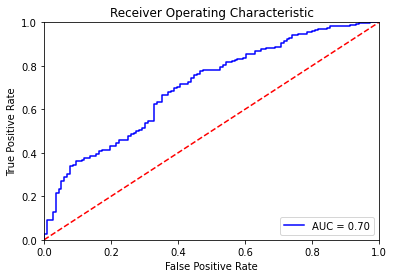

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
PATH = './Model/BERT_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

Tokenizing data...
Number of tweets predicted as Rumor:  122

               precision    recall  f1-score   support

           0       0.29      0.92      0.45       116
           1       0.93      0.31      0.46       369

    accuracy                           0.45       485
   macro avg       0.61      0.61      0.45       485
weighted avg       0.78      0.45      0.46       485

0.4536082474226804
0.4602851323828921


In [ ]:
rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')
X_test = rhi_data.text.values
y_test = rhi_y.isRumor.values

PATH = './Model/BERT_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_test, y_test)

Tokenizing data...
Number of tweets predicted as Rumor:  795

               precision    recall  f1-score   support

           0       0.10      0.94      0.18       475
           1       0.96      0.16      0.28      4752

    accuracy                           0.23      5227
   macro avg       0.53      0.55      0.23      5227
weighted avg       0.89      0.23      0.27      5227

0.23225559594413622
0.27654588065621055


# BERTweet

## Functions

### Libraries

In [2]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, f1_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import time

import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### Functions

In [ ]:
def getDevice():
  if torch.cuda.is_available():       
      device = torch.device("cuda")
      print(f'There are {torch.cuda.device_count()} GPU(s) available.')
      print('Device name:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def text_preprocessing(text): # Create a function to tokenize a set of texts

    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = text.lower()
    # text = re.sub(r'(@.*?)[\s]', ' ', text)
    # text = re.sub(r"(#)(\S+)", r'\1 \2', text)

    # text = re.sub(r"http\S+", "*", text)  # http link -> '*'

    # text = re.sub(r"@\S+", "@", text)   # mention -> '@'
    # text = re.sub(r"@[^\s]+", "@", text)   # mention -> '@'

    # sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)
    # sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocessing_for_bert(data): 

    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs (빈 리스트 2개 생성)
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            # max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask

            # max_length=True,                  # Max length to truncate/pad
            padding='max_length'
        )

        # Add the outputs to the lists (위의 빈 리스트에 상응하는 값 추가)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors (리스트들을 텐서화)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertTweetClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    criterion = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, criterion

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(
                t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(
                    f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def data_process(X_train, y_train, X_val, y_val, batch_size=16):
  # Concatenate train data and test data
  all_tweets = np.concatenate([X_train, X_val])

  # Encode our concatenated data
  encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

  # Find the maximum length
  max_len = max([len(sent) for sent in encoded_tweets])
  print('Max length: ', max_len)

  # Specify `MAX_LEN`
  MAX_LEN = max_len

  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('\nTokenizing data...')
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)

  # Convert other data types to torch.Tensor
  train_labels = torch.tensor(y_train)
  val_labels = torch.tensor(y_val)

  # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 8

  # Create the DataLoader for our training set
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set
  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

  return train_dataloader, val_dataloader

def train_process(train_dataloader, val_dataloader, epoch=4):
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=epoch)

  train(bert_classifier, train_dataloader, loss_fn, epochs=4, evaluation=True)

  return bert_classifier

def testing_process(bert_classifier, X_val, y_val):
  #  Run `preprocessing_for_bert` on the test set
  print('Tokenizing data...')
  test_inputs, test_masks = preprocessing_for_bert(X_val)

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

  # Compute predicted probabilities on the test set
  probs = bert_predict(bert_classifier, test_dataloader)

  # Get predictions from the probabilities
  threshold = 0.5
  preds = np.where(probs[:, 1] > threshold, 1, 0)

  # Number of tweets predicted non-negative
  print("Number of tweets predicted as Rumor: ", preds.sum())

  preds = np.argmax(probs, axis = 1)
  print("\n",classification_report(y_val, preds))
  print('Accuracy Score:\t',accuracy_score(y_val, preds))
  print('Precision Score:\t', str(precision_score(y_val,preds)))
  print('Recall Score:\t\t' + str(recall_score(y_val,preds)))
  print('F1 Score:\t',f1_score(y_val, preds, zero_division=1))

### Class

In [3]:
class BertTweetClassifier(nn.Module): # Create the BertClassfier class
    """Bert Model for Classification Tasks.
    """

    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertTweetClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    def embedding(self, input_ids):
        outputs = self.bert(input_ids=input_ids)

        # outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)

## Execution

In [ ]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv').text.values
rhi_y = pd.read_csv('data/_RHI_text.csv').isRumor

OSError: ignored

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5802,)
(5802,)
(485,)
(485,)


In [ ]:
device = getDevice()
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
train_dataloader, val_dataloader = data_process(X_train, y_train, X_val, y_val, batch_size=8)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


There are 1 GPU(s) available.
Device name: Tesla T4


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Max length:  58

Tokenizing data...


In [ ]:
if torch.cuda.is_available():       
      device = torch.device("cuda")
      print(f'There are {torch.cuda.device_count()} GPU(s) available.')
      print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.657699   |     -      |     -     |   4.73   
   1    |   40    |   0.572159   |     -      |     -     |   4.54   
   1    |   60    |   0.599299   |     -      |     -     |   4.65   
   1    |   80    |   0.502215   |     -      |     -     |   4.70   
   1    |   100   |   0.424222   |     -      |     -     |   4.74   
   1    |   120   |   0.471874   |     -      |     -     |   4.66   
   1    |   140   |   0.555176   |     -      |     -     |   4.64   
   1    |   160   |   0.485429   |     -      |     -     |   4.55   
   1    |   180   |   0.442740   |     -      |     -     |   4.51   
   1    |   200   |   0.574039   |     -      |     -     |   4.47   
   1    |   220   |   0.487704   |     -      |     -     |   4.47   
   1    |   240   |   0.527812   |     -      |     -     |   4.45   


In [ ]:
torch.save(bert_classifier.state_dict(), './Model/BERTweet_raw_to_fine_tune_ord4.pt')

AUC: 0.4855
Accuracy: 62.89%


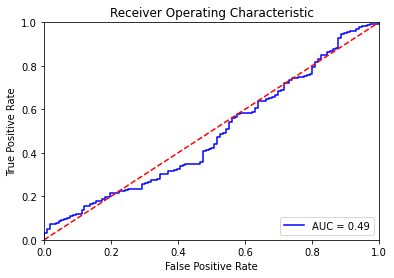

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

Tokenizing data...
Number of tweets predicted as Rumor:  391

               precision    recall  f1-score   support

           0       0.22      0.18      0.20       116
           1       0.76      0.80      0.78       369

    accuracy                           0.65       485
   macro avg       0.49      0.49      0.49       485
weighted avg       0.63      0.65      0.64       485

0.6536082474226804
0.7789473684210527


In [ ]:
rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')
X_test = rhi_data.text.values
y_test = rhi_y.isRumor.values

PATH = './Model/BERTweet_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_test, y_test)

Tokenizing data...
Number of tweets predicted as Rumor:  3823

               precision    recall  f1-score   support

           0       0.11      0.33      0.17       475
           1       0.92      0.74      0.82      4752

    accuracy                           0.70      5227
   macro avg       0.52      0.54      0.49      5227
weighted avg       0.84      0.70      0.76      5227

0.7013583317390473
0.8179591836734694


## Embedding Only

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(epochs=1)
PATH = './Model/BERTweet_raw_to_fine_tune_ord4.pt'
bert_classifier.load_state_dict(torch.load(PATH))
# testing_process(bert_classifier, X_val, y_val)


In [ ]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs (빈 리스트 2개 생성)
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
        )

        # Add the outputs to the lists (위의 빈 리스트에 상응하는 값 추가)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors (리스트들을 텐서화)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [4]:
text = raw_text.text
input_ids, attention_masks = preprocessing_for_bert(text)
# text.dropna(inplace=True)
# text = text.sample(frac=0.4, random_state=999)

# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
# bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# sents = [tokenizer.tokenize(tweet) for tweet in text]
len(input_ids)
# embeddings = []
# for sent in input_ids:
#     with torch.no_grad():
#         features = bert_classifier.embedding(input_ids)
#     embeddings.append(features)

# result = [torch.mean(features.last_hidden_state[-1], dim=0).tolist() for features in embeddings]

last_hidden_states = bert_classifier.embedding(input_ids)
features = last_hidden_states[0][:,0,:].numpy() # considering o only the [CLS] for each sentences 
features.shape


NameError: name 'raw_text' is not defined

In [ ]:
bertweetEmbed = pd.DataFrame(features)
print(bertweetEmbed.shape)


In [ ]:
model.eval()

all_logits = []

# For each batch in our test set...
for batch in test_dataloader:
    # Load batch to GPU
    b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

    # Compute logits
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
    all_logits.append(logits)

# Concatenate logits from each batch
all_logits = torch.cat(all_logits, dim=0)

# Apply softmax to calculate probabilities
probs = F.softmax(all_logits, dim=1).cpu().numpy()

return probs
